In [ ]:
# Colab Fast Start (Around 5 minutes)
# Clone the repositories
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!git clone https://github.com/salesforce/BLIP
# Install the requirements
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 ninja==1.11.1.1
!pip install ftfy==6.1.3 regex==2023.12.25 tqdm==4.66.2
!pip install transformers==4.19.4 timm==0.9.16 fairscale==0.4.13
# Download the pre-trained models
!mkdir pretrained_models
!gdown -O test.png https://drive.google.com/uc?id=1hfVAbs5nkXcUpG6FCAafid7F7ZsqRRkk
!curl -L --output pretrained_models/stylegan2-afhqcat-512x512.pkl 'https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-afhqcat-512x512.pkl'
!curl -L --output pretrained_models/ViT-B-32.pt 'https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt'
!curl -L --output pretrained_models/model_base_capfilt_large.pth https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth

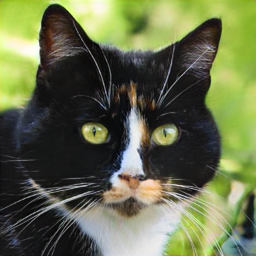

In [2]:
# Stylegan2-ADA-PyTorch Implementation for Stylegan3 https://github.com/NVlabs/stylegan3

# Requirements:
# !conda install pytorch=2.1.2 torchvision=0.16.2 torchaudio=2.1.2 -c pytorch
# !conda install ninja==1.11.1.1 # only needed if you use cuda
# !conda install pytorch-cuda=11.8 -c nvidia # only needed if you use cuda

# Download pretrained model to pwd/pretrained_models directory from:
# !curl -LO 'https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-afhqcat-512x512.pkl'

import sys
sys.path.append('stylegan3') # a folder stylegan3 is in the same directory as this notebook

import pickle
import torch
import PIL.Image
from IPython.display import display

device = "cuda" if torch.cuda.is_available() else "cpu"

with open('pretrained_models/stylegan2-afhqcat-512x512.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
z = torch.randn([1, G.z_dim]).to(device)    # random latent codes
#z = clipout.to(device)                       # THIS IS OUR AIM #TODO # Optimize this tensor
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1], no truncation

img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
outdir = 'out'
seed = 6
# PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png') # save image
img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((256, 256))
display(img)

In [9]:
# CLIP - Contrastive Language-Image Pretraining (OpenAI) https://github.com/openai/CLIP

# Requirements: ftfy regex tqdm
# !conda install ftfy=6.1.3 regex=2023.12.25 tqdm=4.66.2

# Download pretrained model to pwd/pretrained_models directory from:
# !curl -LO 'https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt'

import torch
import CLIP.clip.clip as clip # to use class in: pwd/CLIP/clip/clip.py
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("pretrained_models/ViT-B-32.pt", device=device)

image = preprocess(Image.open("test.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a cat with green eyes"]).to(device)
# text = clip.tokenize([blipout]).to(device)  # To convert caption(blip output) to tensor using clip

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Image-text similarity:", logits_per_image.cpu().numpy())  # prints: [[24.815384]]
print("Label probabilities:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
print("Image features (tensor size): ",len(image_features[0]))
print("Text features (tensor size): ",len(text_features[0]))

#z = torch.randn([1, G.z_dim]).cpu()   # random latent codes
clipout = text_features                # THIS IS OUR AIM #TODO
#it is same size tensor but output of stylegan2 is different image

Image-text similarity: [[28.738464]]
Label probabilities: [[1.]]
Image features (tensor size):  512
Text features (tensor size):  512


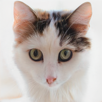

reshape position embedding from 196 to 1024
load checkpoint from pretrained_models/model_base_capfilt_large.pth
caption: a cat with green eyes


In [1]:
# BLIP - Bootstrapping Language-Image Pretraining https://github.com/salesforce/BLIP

# Requirements:
# !conda install transformers=4.19.4 timm=0.9.16 fairscale=0.4.13

# Download pretrained model to pwd/pretrained_models directory from:
# !curl -LO https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth

import sys
sys.path.append('BLIP') # a folder BLIP is in the same directory as this notebook

from BLIP.models.blip import blip_decoder # to use class in: pwd/BLIP/models/blip.py

from PIL import Image
import requests
import os
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 512


raw_image = Image.open('test.png').convert('RGB')
w,h = raw_image.size
display(raw_image.resize((w//5,h//5)))

transform = transforms.Compose([
    transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
image = transform(raw_image).unsqueeze(0).to(device)

model_url = 'pretrained_models/model_base_capfilt_large.pth'

med_config_path = os.getcwd() + '/BLIP/configs/med_config.json'
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base', med_config = med_config_path)

#model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
    print('caption: '+caption[0])

blipout = caption[0]